In [29]:
# Imports
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enable pretty plots
sns.set(style="darkgrid")


In [30]:
# Parse training log into per-model-per-epoch contributions

log_path = 'training_log.txt'

with open(log_path, 'r') as f:
    lines = f.readlines()

# Data structure for flattened model-wise stats
records = []

float_pattern = r"-?\d+\.\d+"

for epoch_idx, line in enumerate(lines):
    games_played = int(re.search(r"Games Played:\s+(\d+)", line).group(1))
    
    for model in ['blue', 'green', 'red']:
        loss_match = re.search(rf"{model}\s+Avg Loss:\s+({float_pattern})", line)
        reward_match = re.search(rf"{model}\s+Avg Reward:\s+({float_pattern})", line)
        
        if loss_match and reward_match:
            records.append({
                'model': model,
                'epoch_line': epoch_idx + 1,
                'games_played_in_epoch': games_played // 2,  # two models per epoch
                'avg_loss': float(loss_match.group(1)),
                'avg_reward': float(reward_match.group(1)),
            })

# Create DataFrame
df = pd.DataFrame(records)
# Calculate total games played per model
df['cumulative_games'] = df.groupby('model')['games_played_in_epoch'].cumsum()
df.head()


,model,epoch_line,games_played_in_epoch,avg_loss,avg_reward,cumulative_games
0,blue,1,125,-0.081412,2.203556,125
1,red,1,125,-0.079807,1.703558,125
2,blue,2,125,-0.079723,2.145910,250
3,red,2,125,-0.084596,1.768614,250
4,blue,3,125,-0.079381,1.585455,375


In [31]:
# Apply rolling average for smoothing
window = 200  # Adjust for more/less smoothing
df['smoothed_reward'] = df.groupby('model')['avg_reward'].transform(lambda x: x.rolling(window, min_periods=1).mean())
df['smoothed_loss'] = df.groupby('model')['avg_loss'].transform(lambda x: x.rolling(window, min_periods=1).mean())


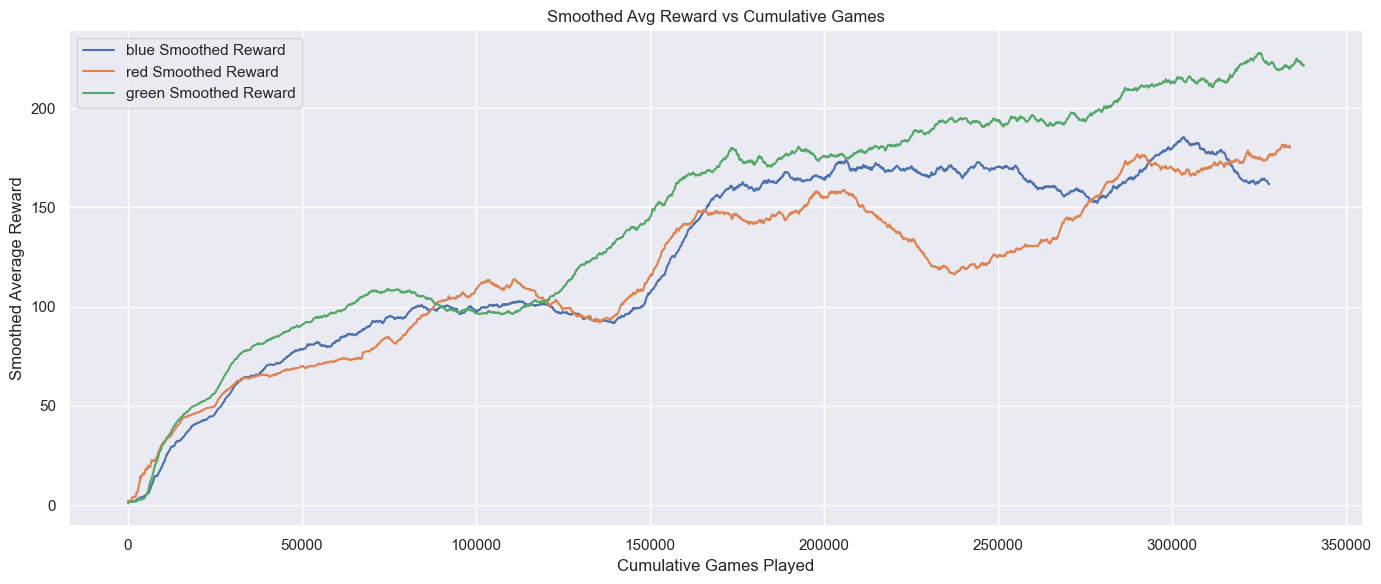

In [32]:
# Smoothed reward plot
plt.figure(figsize=(14, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    plt.plot(model_data['cumulative_games'], model_data['smoothed_reward'], label=f"{model} Smoothed Reward")

plt.title("Smoothed Avg Reward vs Cumulative Games")
plt.xlabel("Cumulative Games Played")
plt.ylabel("Smoothed Average Reward")
plt.legend()
plt.tight_layout()
plt.savefig("Smoothed Avg Reward vs Cumulative Games")
plt.show()



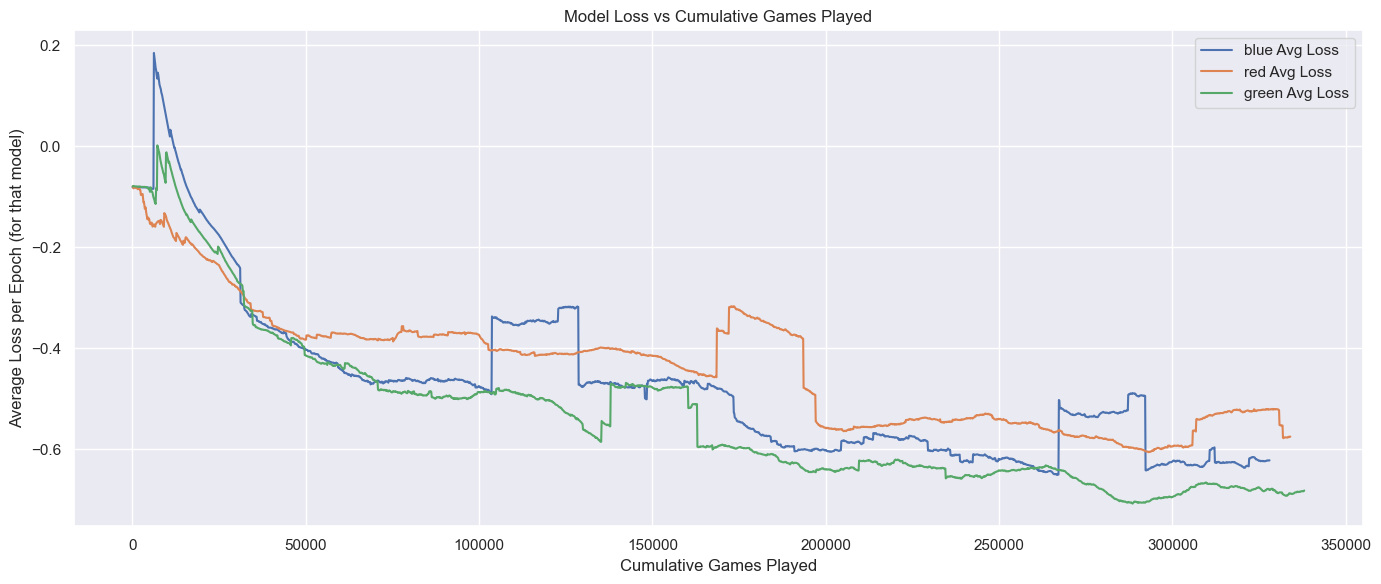

In [33]:
# Plot loss vs cumulative games played

plt.figure(figsize=(14, 6))
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    plt.plot(model_data['cumulative_games'], model_data['smoothed_loss'], label=f"{model} Avg Loss")

plt.title("Model Loss vs Cumulative Games Played")
plt.xlabel("Cumulative Games Played")
plt.ylabel("Average Loss per Epoch (for that model)")
plt.legend()
plt.tight_layout()
plt.savefig("Model Loss vs Cumulative Games Played.png")
plt.show()



In [34]:
# Show summary statistics per model
summary = df.groupby('model').agg({
    'games_played_in_epoch': 'sum',
    'avg_reward': ['mean', 'std', 'min', 'max'],
    'avg_loss': ['mean', 'std', 'min', 'max']
})

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary.reset_index()


,model,games_played_in_epoch_sum,avg_reward_mean,avg_reward_std,avg_reward_min,avg_reward_max,avg_loss_mean,avg_loss_std,avg_loss_min,avg_loss_max
0,blue,328000,129.993007,63.284894,0.887991,380.079407,-0.496020,0.926908,-0.914943,30.412386
1,green,338000,154.146990,71.196433,0.792186,535.637085,-0.554783,0.442373,-0.929654,16.270275
2,red,334000,123.303592,65.964705,1.548726,364.683929,-0.454094,0.480270,-0.814814,18.867794


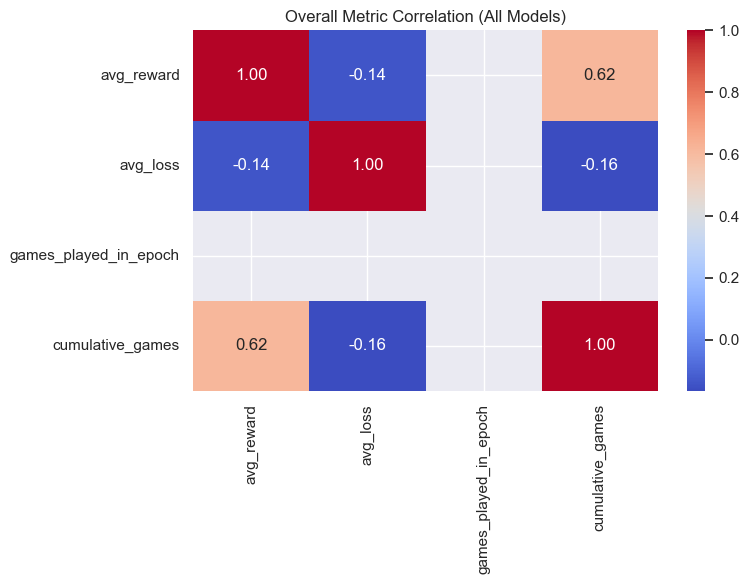

In [35]:
# Overall correlation between metrics
plt.figure(figsize=(8, 6))
corr = df[['avg_reward', 'avg_loss', 'games_played_in_epoch', 'cumulative_games']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Overall Metric Correlation (All Models)")
plt.tight_layout()
plt.savefig("Overall Metric Correlation (All Models).png")
plt.show()
